In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, LeakyReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam, schedules
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score

This project addresses the "Digit Recognizer" challenge hosted on Kaggle. The core objective is to develop a robust classification model capable of accurately identifying handwritten digits, ranging from 0 to 9, based on provided image data. This notebook details the end-to-end process, from data loading and preprocessing to model architecture design (utilizing Convolutional Neural Networks), training, evaluation, and ultimately, generating predictions for submission. The aim is to achieve high accuracy in recognizing these handwritten digits, showcasing the power of deep learning in image classification tasks.

### Data Preparation - MNIST

Initially, we will load and preprocess the MNIST dataset images. This preprocessing involves several crucial steps: checking for null values, normalizing the pixel data, reshaping the images to the appropriate format, and converting the labels to a categorical (one-hot encoded) representation.

Next, we will implement Data Augmentation, an advanced technique designed to expand our training dataset. By applying random transformations to the existing images, data augmentation generates more diverse examples for the model to learn from. This process is instrumental in preventing overfitting and enhancing the model's generalization capabilities.

In [2]:
# Loading data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(f"Train images: {train.shape[0]}\nTest images: {test.shape[0]}")

Train images: 42000
Test images: 28000


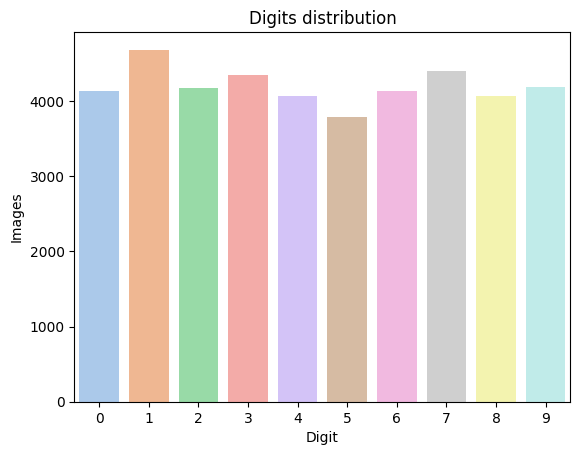

In [ ]:
# Separate labels and features
Y_train = train["label"]
X_train = train.drop("label", axis=1)

# Digits distribution
sns.countplot(x=Y_train, hue=Y_train, palette=("pastel"), legend=False)
plt.xlabel("Digit")
plt.ylabel("Images")
plt.title("Digits distribution")
plt.show()

In [4]:
# Checking nulls
print("Train Nulls:", X_train.isnull().values.sum())
print("Test Nulls:", test.isnull().values.sum())

Train Nulls: 0
Test Nulls: 0


In [ ]:
# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
test = test / 255.0

In [6]:
# Reshape
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [ ]:
# One-hot encode labels
Y_train = to_categorical(Y_train, num_classes = 10)

In [8]:
# Split Training and Validation Set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

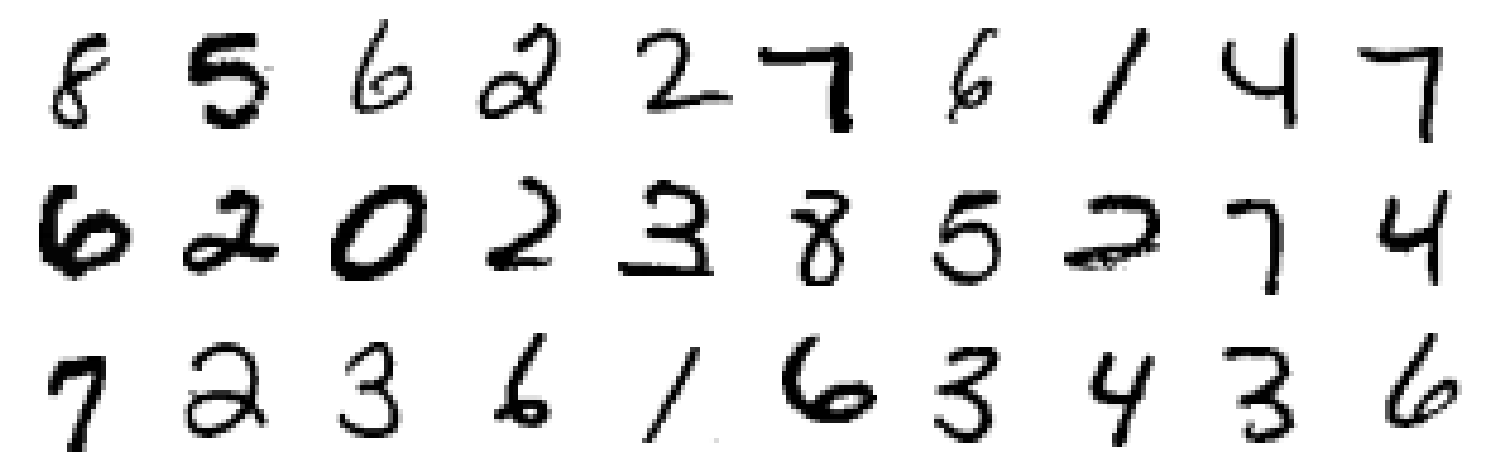

In [9]:
# Plotting example digits
plt.figure(figsize=(15,5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap="binary")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# Data generation for data augmentation
datagen = ImageDataGenerator(rotation_range=10, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1,
                            shear_range=0.1, horizontal_flip=False, vertical_flip=False, fill_mode='constant', cval=0)

### CNN + TTA

The CNN model architecture consists of three convolutional blocks and a single fully connected layer. To prevent overfitting and promote stable training, the model utilizes L2 weight regularization, He Normal initialization, Swish activation functions, Batch Normalization, and progressive dropout.

Advanced techniques were implemented to further enhance model performance. A Cosine Decay Learning Rate Scheduler was employed for smoother convergence, and Test Time Augmentation (TTA), leveraging the data augmentation generator during inference, significantly improved the model's generalization capabilities.

Hyperparameters were meticulously tuned through manual analysis of the training process, leveraging insights from the loss and accuracy curves across both training and validation sets, to identify the optimal parameter configuration for the model.

In [ ]:
def create_cnn(l2_value=1e-4):
    reg = l2(l2_value)

    model = Sequential()

    # 1. Convolutional Block
    model.add(Conv2D(32, kernel_size=(3,3), padding='Same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=reg, input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Activation('swish'))

    model.add(Conv2D(64, kernel_size=(3,3), padding='Same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Activation('swish'))

    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    # 2. Convolutional Block
    model.add(Conv2D(128, kernel_size=(3,3), padding='Same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Activation('swish'))

    model.add(Conv2D(128, kernel_size=(3,3), padding='Same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Activation('swish'))

    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # 3. Convolutional Block
    model.add(Conv2D(256, kernel_size=(3,3), padding='Same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Activation('swish'))

    model.add(Conv2D(256, kernel_size=(3,3), padding='Same', use_bias=False, kernel_initializer='he_normal', kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Activation('swish'))

    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    # 4. Fully Connected Block
    model.add(Flatten())
    model.add(Dense(256, use_bias=False, kernel_initializer='he_normal', kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Activation('swish'))
    model.add(Dropout(0.5))
    
    # Output Layer
    model.add(Dense(10, activation="softmax"))

    return model

In [ ]:
# Create and compile the model with the following parameters
epochs = 150
batch_size = 64

total_steps = epochs * (len(X_train) // batch_size)

train_gen = datagen.flow(X_train, Y_train, batch_size=batch_size)

# es = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True) 
# rlr = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, factor = 0.5, min_lr = 1e-6)
mc_loss = ModelCheckpoint('best_model_ind.h5', monitor = 'val_loss', save_best_only = True, mode = 'min')
callbacks = [mc_loss]

lr_schedule = tf.optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps=total_steps, alpha=0.0)
optimizer = Adam(learning_rate=lr_schedule)
loss = CategoricalCrossentropy(label_smoothing=0.05)

model = create_cnn()
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        288       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18432     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 28, 28, 64)        0

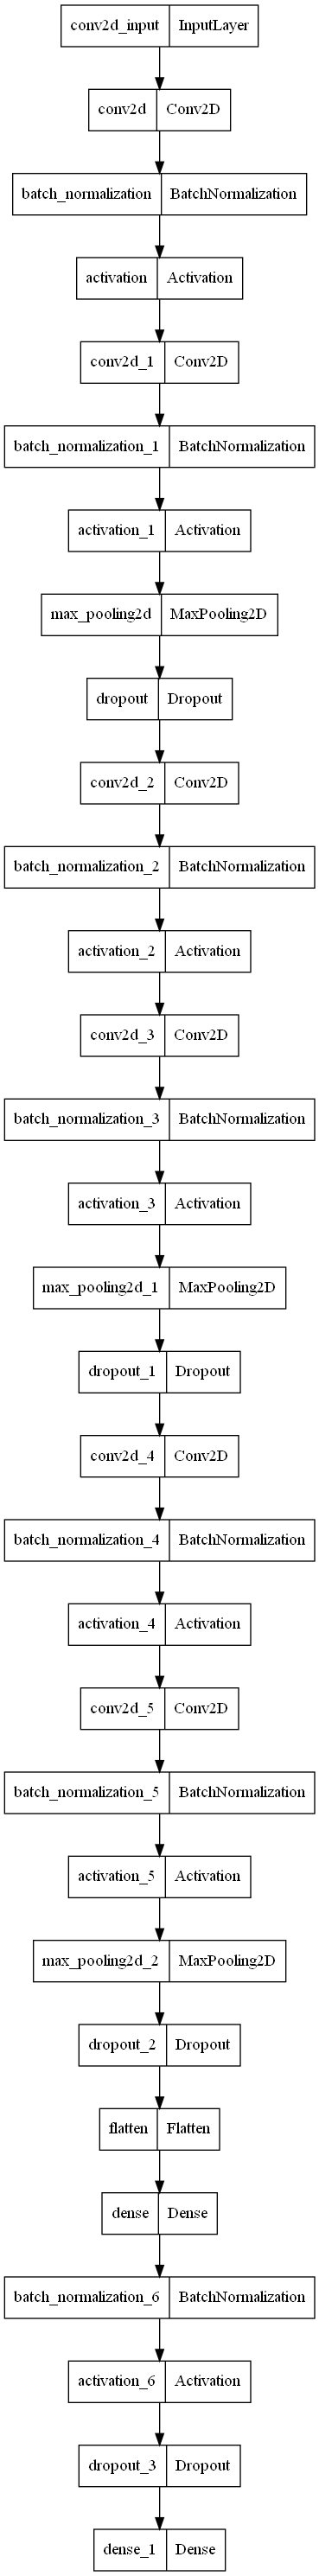

In [ ]:
# Visualize the model
plot_model(model)

In [ ]:
# Training the model
learning_hist = model.fit(train_gen, epochs = epochs, validation_data = (X_val, Y_val), callbacks=callbacks)

Epoch 1/150
591/591 [==============================] - 19s 26ms/step - loss: 0.7810 - accuracy: 0.9216 - val_loss: 0.5876 - val_accuracy: 0.9850
Epoch 2/150
591/591 [==============================] - 14s 24ms/step - loss: 0.5875 - accuracy: 0.9790 - val_loss: 0.5250 - val_accuracy: 0.9895
Epoch 3/150
591/591 [==============================] - 14s 24ms/step - loss: 0.5268 - accuracy: 0.9839 - val_loss: 0.4663 - val_accuracy: 0.9926
Epoch 4/150
591/591 [==============================] - 15s 25ms/step - loss: 0.4792 - accuracy: 0.9867 - val_loss: 0.4387 - val_accuracy: 0.9902
Epoch 5/150
591/591 [==============================] - 15s 25ms/step - loss: 0.4475 - accuracy: 0.9875 - val_loss: 0.4243 - val_accuracy: 0.9900
Epoch 6/150
591/591 [==============================] - 15s 25ms/step - loss: 0.4290 - accuracy: 0.9874 - val_loss: 0.3918 - val_accuracy: 0.9926
Epoch 7/150
591/591 [==============================] - 15s 25ms/step - loss: 0.4157 - accuracy: 0.9874 - val_loss: 0.3871 - val_ac

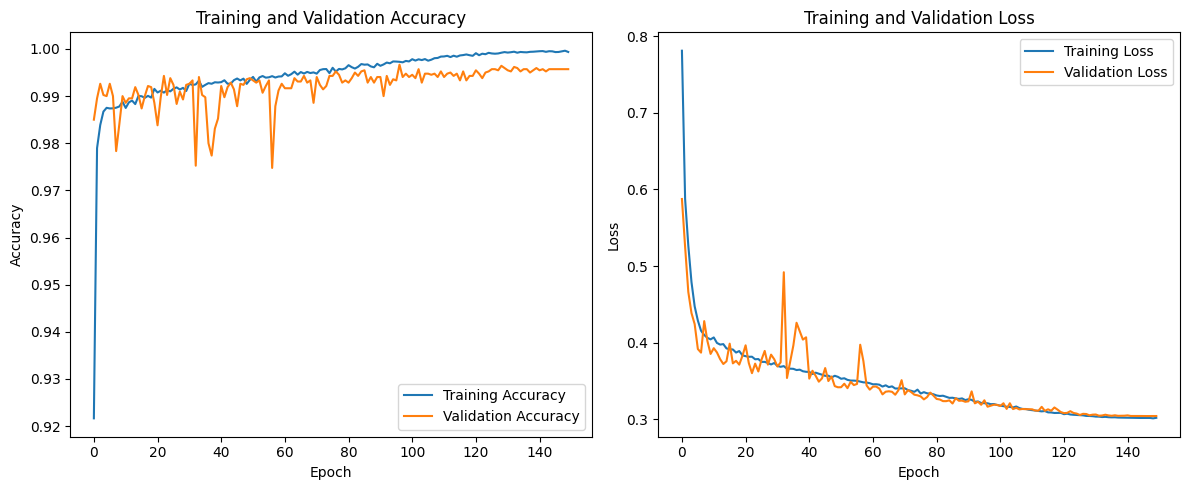

In [ ]:
# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(learning_hist.history['accuracy'], label='Training Accuracy')
plt.plot(learning_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(learning_hist.history['loss'], label='Training Loss')
plt.plot(learning_hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Test Time Augmentation for better generalization in predictions
loops = 10

def tta_prediction(model, datagen, X_test, loops, batch_size):
    probs = np.zeros((len(X_test), 10))
    
    for i in range(loops):
        test_gen = datagen.flow(X_test, batch_size=batch_size, shuffle=False)
        probs += model.predict(test_gen, batch_size=batch_size, verbose=0)
        
    probs /= loops
    return probs

In [ ]:
# Checking the upgrade of TTA
model = load_model('best_model_ind.h5')
y_true = np.argmax(Y_val, axis=1)

# ACC individual model
print("1. Starting NORMAL predictions...")

preds_normal = model.predict(X_val, batch_size=batch_size, verbose=0)
classes_normal = np.argmax(preds_normal, axis=1)

acc_normal = accuracy_score(y_true, classes_normal)
print(f"Accuracy NORMAL: {acc_normal:.5f}\n")

# ACC individual model with TTA
print(f"2. Starting TTA predictions ({loops} loops)...")

preds_tta_probs = tta_prediction(model, datagen, X_val, loops, batch_size)
classes_tta = np.argmax(preds_tta_probs, axis=1)

acc_tta = accuracy_score(y_true, classes_tta)
print(f"Accuracy TTA: {acc_tta:.5f}\n")

mejora = acc_tta - acc_normal
errors_normal = len(y_true) - np.sum(classes_normal == y_true)
errors_tta = len(y_true) - np.sum(classes_tta == y_true)

print(f"RESULTS:")
print(f"Errors (Normal): {errors_normal}")
print(f"Errors (TTA):    {errors_tta}")

1. Iniciando predicción NORMAL...
Accuracy NORMAL: 0.99571

2. Iniciando predicción TTA (10 loops)...
Accuracy TTA: 0.99619

RESULTADOS:
Diferencia: +0.00048 (MEJORA)
Imágenes falladas (Normal): 18
Imágenes falladas (TTA):    16


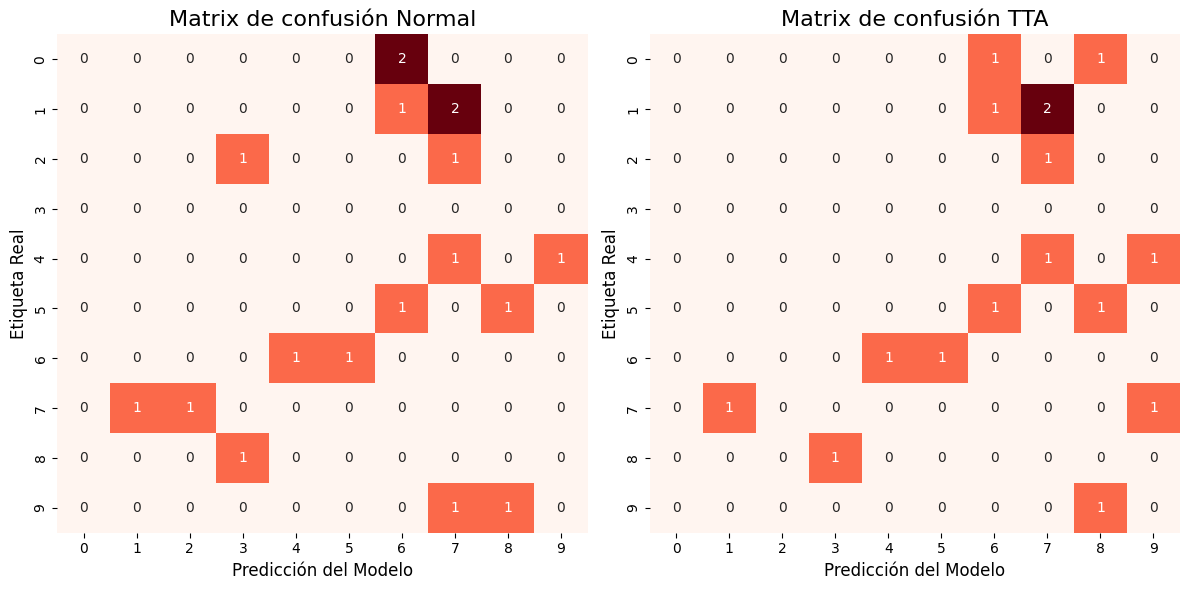

In [ ]:
# Plotting confusion matrix of both techniques
plt.figure(figsize=(12, 6))

# Confusion matrix NORMAL
plt.subplot(1, 2, 1)

cm_norm = confusion_matrix(y_true, classes_normal)
np.fill_diagonal(cm_norm, 0)

sns.heatmap(cm_norm, annot=True, fmt='d', cmap='Reds', cbar=False)

plt.title('Confusion matrix Normal', fontsize=16)
plt.ylabel('Real Label', fontsize=12)
plt.xlabel('Model Prediction', fontsize=12)

# Confusion matrix TTA
plt.subplot(1, 2, 2)

cm_tta = confusion_matrix(y_true, classes_tta)
np.fill_diagonal(cm_tta, 0)

sns.heatmap(cm_tta, annot=True, fmt='d', cmap='Reds', cbar=False)

plt.title('Confusion matrix TTA', fontsize=16)
plt.ylabel('Real Label', fontsize=12)
plt.xlabel('Model Prediction', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Loading model and saving predictions for submission
model = load_model('best_model_ind.h5')

preds_tta = tta_prediction(model, datagen, test, loops, batch_size)
preds_tta = np.argmax(preds_tta, axis=1)
preds_tta = pd.Series(preds_tta, name="Label")

print(f"Saving predictions of individual model with TTA...")
submission_tta = pd.concat([pd.Series(range(1, len(preds_tta) + 1), name="ImageId"), preds_tta], axis=1)
submission_tta.to_csv("CNN_keras_submission_individual.csv", index=False)

Guardando predicciones del modelo individual...


### CNN Ensemble + TTA

To take the next step in this project and achieve truly extraordinary results, we implemented an advanced technique called K-Fold Cross-Validation Ensemble strategy, wich, combined with previously used techniques, will allow us to significantly improve our outcomes. 

We trained 5 independent instances of our CNN model, each using a different subset of the training data, ensuring that the ensemble as a whole has been trained on the complete dataset. During the inference phase, we aggregate the predictions of all models, further enhanced by Test Time Augmentation (TTA), a combination that is statistivally more robust and reliable than any single model.

In [ ]:
# Training with KFold Cross Validation with same model architecture
n_folds = 5
epochs = 150
batch_size = 64

X_full = np.concatenate((X_train, X_val))
Y_full = np.concatenate((Y_train, Y_val))
Y_full_labels = np.argmax(Y_full, axis=1)

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

fold_no = 1
for train_index, val_index in kfold.split(X_full, Y_full_labels):
    print(f"\Training FOLD {fold_no}/{n_folds}")
    
    X_train, X_val_fold = X_full[train_index], X_full[val_index]
    Y_train, Y_val_fold = Y_full[train_index], Y_full[val_index]
    
    model = create_cnn()
    
    total_steps = epochs * (len(X_train) // batch_size)
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps=total_steps, alpha=0.0)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    loss = CategoricalCrossentropy(label_smoothing=0.05)
    
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    checkpoint_name = f'best_model_fold_{fold_no}.h5'
    mc = ModelCheckpoint(checkpoint_name, monitor='val_loss', save_best_only=True, mode = 'min')
    
    train_gen = datagen.flow(X_train, Y_train, batch_size=batch_size)

    learning_hist = model.fit(train_gen, epochs = epochs, validation_data = (X_val_fold, Y_val_fold), callbacks=[mc])
    
    fold_no += 1


ENTRENANDO FOLD 1/5
Epoch 1/150
525/525 [==============================] - 15s 26ms/step - loss: 0.8096 - accuracy: 0.9117 - val_loss: 0.5956 - val_accuracy: 0.9862
Epoch 2/150
525/525 [==============================] - 14s 26ms/step - loss: 0.6038 - accuracy: 0.9768 - val_loss: 0.5360 - val_accuracy: 0.9875
Epoch 3/150
525/525 [==============================] - 14s 26ms/step - loss: 0.5423 - accuracy: 0.9832 - val_loss: 0.4825 - val_accuracy: 0.9910
Epoch 4/150
525/525 [==============================] - 14s 26ms/step - loss: 0.4955 - accuracy: 0.9855 - val_loss: 0.4627 - val_accuracy: 0.9890
Epoch 5/150
525/525 [==============================] - 14s 26ms/step - loss: 0.4629 - accuracy: 0.9867 - val_loss: 0.4185 - val_accuracy: 0.9914
Epoch 6/150
525/525 [==============================] - 14s 26ms/step - loss: 0.4398 - accuracy: 0.9874 - val_loss: 0.4228 - val_accuracy: 0.9874
Epoch 7/150
525/525 [==============================] - 14s 26ms/step - loss: 0.4245 - accuracy: 0.9879 - val_

In [ ]:
# Function to perform Ensemble + TTA
def ensemble_prediction(n_folds, datagen, X_test, loops, batch_size):
    
    ensemble_probs = np.zeros((len(X_test), 10))
    fold_models = [f'best_model_fold_{i}.h5' for i in range(1, n_folds)]

    print("Iniciando Ensemble + TTA...")
    for model in fold_models:
        print(f"Cargando {model}...")  
        model_temp = load_model(model)

        probs_fold = tta_prediction(model_temp, datagen, X_test, loops, batch_size)

        ensemble_probs += probs_fold

    ensemble_probs /= len(fold_models)
    
    return ensemble_probs

In [ ]:
# Checking upgrade of ensemble + TTA
model = load_model('best_model_ind.h5')
y_true = np.argmax(Y_val, axis=1)

# ACC individual model
print("1. Starting NORMAL predictions...")

preds_normal = model.predict(X_val, batch_size=batch_size, verbose=0)
classes_normal = np.argmax(preds_normal, axis=1)

acc_normal = accuracy_score(y_true, classes_normal)
print(f"Accuracy NORMAL: {acc_normal:.5f}\n")

# ACC individual model with TTA
print(f"2. Starting TTA predictions ({loops} loops)...")

preds_tta_probs = tta_prediction(model, datagen, X_val, loops, batch_size)
classes_tta = np.argmax(preds_tta_probs, axis=1)

acc_tta = accuracy_score(y_true, classes_tta)
print(f"Accuracy TTA: {acc_tta:.5f}\n")

# ACC Ensemble + TTA
print(f"3. Starting ENSEMBLE + TTA predictions ({n_folds} folds + {loops} loops)...")

preds_ens_probs = ensemble_prediction(n_folds, datagen, X_val, loops, batch_size)
classes_ens = np.argmax(preds_ens_probs, axis=1)

acc_ens = accuracy_score(y_true, classes_ens)
print(f"Accuracy ENSEMBLE + TTA: {acc_ens:.5f}\n")

errors_normal = len(y_true) - np.sum(classes_normal == y_true)
errors_tta = len(y_true) - np.sum(classes_tta == y_true)
errors_ens = len(y_true) - np.sum(classes_ens == y_true)

print(f"RESULTS:")
print(f"Errors (Normal): {errors_normal}")
print(f"Errors (TTA):    {errors_tta}")
print(f"Errors (ENSEMBLE + TTA): {errors_ens}")

Cargando mejor modelo por test loss

1. Iniciando predicción NORMAL...
Accuracy NORMAL: 0.99571

2. Iniciando predicción TTA (10 loops)...
Accuracy TTA: 0.99643

3. Iniciando predicción ENSEMBLE + TTA (5 folds + 10 loops)...
Iniciando Ensemble + TTA...
Cargando best_model_fold_1.h5...
Cargando best_model_fold_2.h5...
Cargando best_model_fold_3.h5...
Cargando best_model_fold_4.h5...
Accuracy ENSEMBLE + TTA: 1.00000

RESULTADOS:
Imágenes falladas (Normal): 18
Imágenes falladas (TTA):    15
Imágenes falladas (ENSEMBLE + TTA): 0


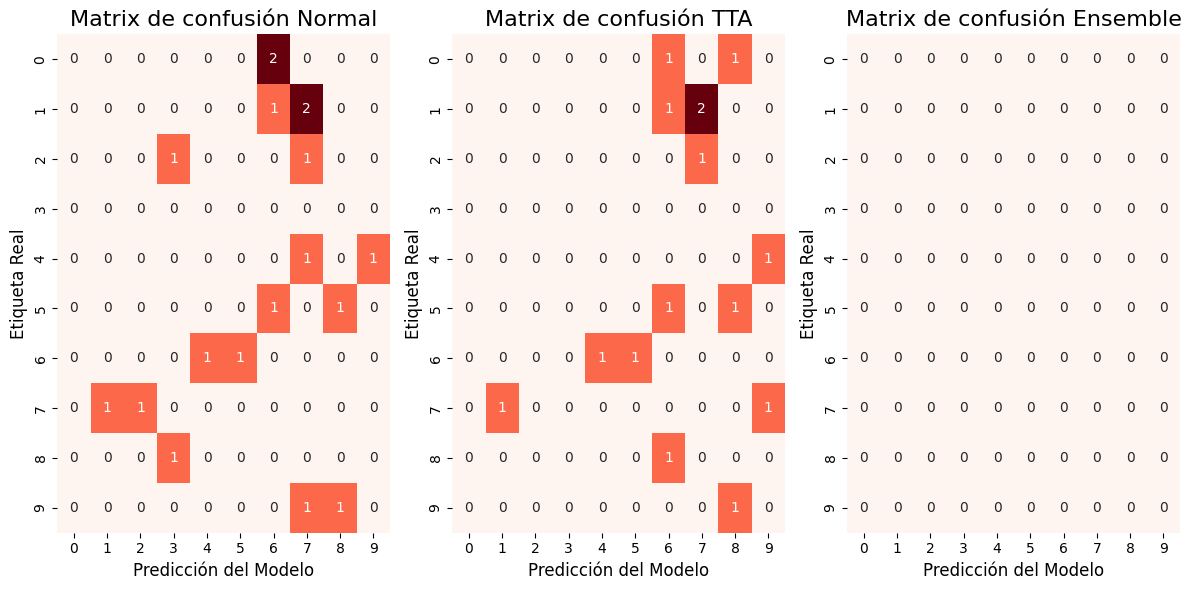

In [ ]:
# Plotting confusion matrix of all techniques
plt.figure(figsize=(12, 6))

# Confusion matrix Normal
plt.subplot(1, 3, 1)

cm_norm = confusion_matrix(y_true, classes_normal)
np.fill_diagonal(cm_norm, 0)

sns.heatmap(cm_norm, annot=True, fmt='d', cmap='Reds', cbar=False)

plt.title('Confusion matrix Normal', fontsize=16)
plt.ylabel('Real Label', fontsize=12)
plt.xlabel('Model Prediction', fontsize=12)

# Confusion matrix TTA
plt.subplot(1, 3, 2)

cm_tta = confusion_matrix(y_true, classes_tta)
np.fill_diagonal(cm_tta, 0)

sns.heatmap(cm_tta, annot=True, fmt='d', cmap='Reds', cbar=False)

plt.title('Confusion Matrix TTA', fontsize=16)
plt.ylabel('Real Label', fontsize=12)
plt.xlabel('Model Prediction', fontsize=12)

# Confusion matrix Ensemble
plt.subplot(1, 3, 3)

cm_ens = confusion_matrix(y_true, classes_ens)
np.fill_diagonal(cm_ens, 0)

sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Reds', cbar=False)

plt.title('Confusion matrix Ensemble', fontsize=16)
plt.ylabel('Real Label', fontsize=12)
plt.xlabel('Model Prediction', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Making predictions for test set with the ensemble and saving them for submission
ensemble_probs = ensemble_prediction(n_folds, datagen, test, loops, batch_size)
ensemble_preds = np.argmax(ensemble_probs, axis=1)
ensemble_preds = pd.Series(ensemble_preds, name="Label")

print("Guardando predicciones del ensemble...")
submission_ens = pd.concat([pd.Series(range(1, len(ensemble_preds) + 1), name="ImageId"), ensemble_preds], axis=1)
submission_ens.to_csv("CNN_keras_submission_ensemble.csv", index=False)

Iniciando Ensemble + TTA...
Cargando best_model_fold_1.h5...
Cargando best_model_fold_2.h5...
Cargando best_model_fold_3.h5...
Cargando best_model_fold_4.h5...
Guardando predicciones del ensemble...


### Conclusions and Insights

The final outcome of this project is exceptional. Every stage of the pipeline—from data preparation and architectural design to specific training strategies—contributed synergistically to the result, proving that a careful combination of techniques yields better performance than the sum of its parts.

While MNIST is often considered a solved problem for basic models, pushing accuracy into the elite tier presents a significant engineering challenge. Beyond a certain threshold, achieving even fractional improvements requires a sophisticated stack of advanced techniques, such as the ones explored here.

These efforts culminated in a final test accuracy greater than 99.7%, securing a position in the Top 3% of the Kaggle leaderboard. This result represents an optimal equilibrium between computational effort and performance. While further marginal gains are theoretically possible through even more aggressive methods, the current state stands as a highly robust, production-grade solution where the diminishing returns of further complexity do not justify the cost.